In [1]:
import numpy as np

import mlgrad.avragg as avragg
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.regnorm as regular

from mlgrad.regr import averaging_function, regression, m_regression_irls, \
                        r_regression_irls, m_regression, \
                        plot_losses_and_errors, plot_yy, exclude_outliers

from mlgrad import erm_fg, erm_sg, erm_irgd, fg, fg_rud, sg, weights, averager_it, erisk, mrisk

from pprint import pprint

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import sys
print(sys.version)

3.9.9 (main, Jan 10 2022, 10:55:59) 
[GCC 11.2.0]


In [2]:
X, Y = load_boston(return_X_y=True)
# print(X.shape)

# Is = [i for i,y in enumerate(Y) if y != 50]
# X = X[Is]
# Y = Y[Is]

scaler = StandardScaler()
Xt = scaler.fit_transform(X)


In [3]:
def sigma_neuron_layer2(n_input, n_output):
    outfunc = func.Arctang()
    layer = model.SigmaNeuronModelLayer(outfunc, n_input, n_output)
    return layer

In [4]:
def create_nn(n_input, n_layers):
    body = model.FFNetworkModel()
    n_prev_layer = n_input
    for n_layer in n_layers:
        layer = sigma_neuron_layer2(n_prev_layer, n_layer)
        n_prev_layer = n_layer
        body.add(layer)

    head = model.LinearModel(n_layers[-1])
    ffnn = model.FFNetworkFuncModel(head, body)
    ffnn.allocate()
    return ffnn

In [5]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_sqrt = loss.ErrorLoss(func.Sqrt(1.0))

In [6]:
n_hidden1 = 27
n_hidden2 = 13
n_layers = (n_hidden1, n_hidden2)
n_input = Xt.shape[1]

In [7]:
ffnn1 = create_nn(n_input, n_layers)
ffnn1.init_param()
ffnn2 = create_nn(n_input, n_layers)
ffnn2.init_param()
ffnn3 = create_nn(n_input, n_layers)
ffnn3.init_param()
ffnn4 = create_nn(n_input, n_layers)
ffnn4.init_param()
ffnn5 = create_nn(n_input, n_layers)
ffnn5.init_param()

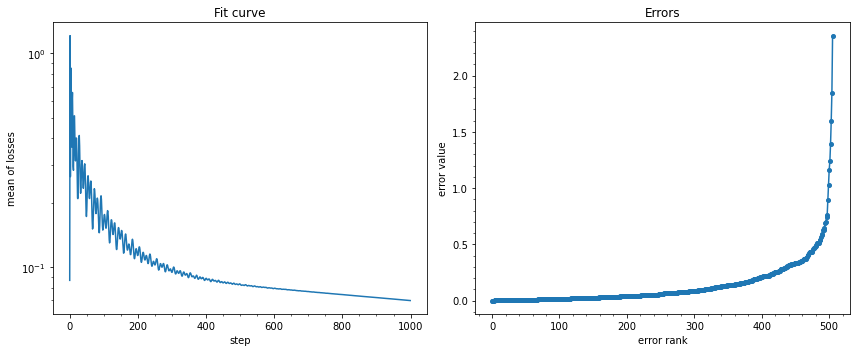

In [14]:
fg_bp = regression(Xt, Y, ffnn1, h=0.01, tol=1.0e-9, n_restart=5, n_iter=1000)
plot_losses_and_errors(fg_bp, Xt, Y)

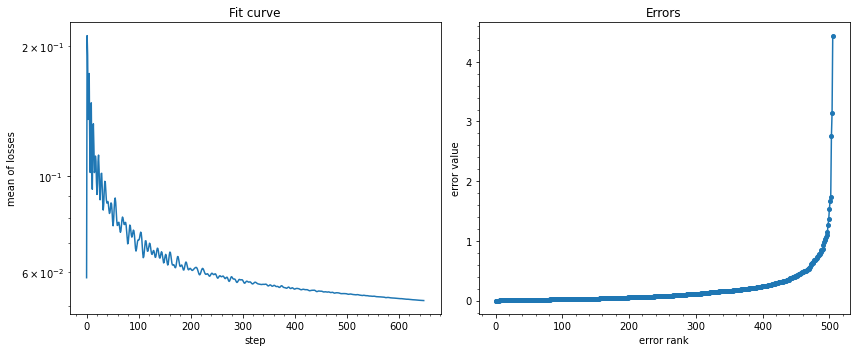

In [15]:
fg_sqrt = regression(Xt, Y, ffnn2, loss_func_sqrt, h=0.01, tol=1.0e-9, n_restart=5, n_iter=1000)
plot_losses_and_errors(fg_sqrt, Xt, Y)

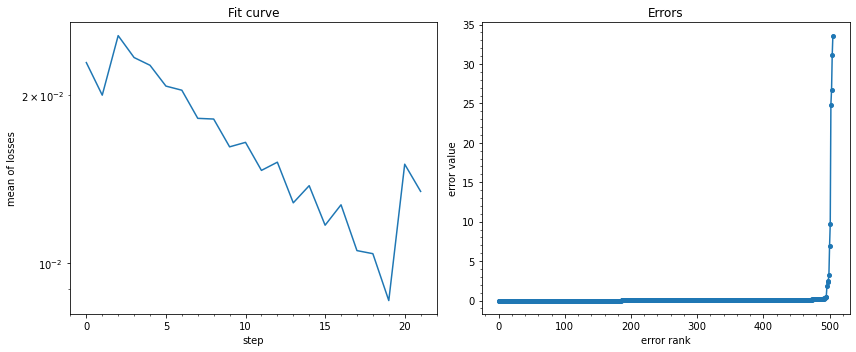

In [16]:
avg_wm = averaging_function("WM", rhofunc=func.Sqrt(0.001), alpha=0.98)
irgd_wm = m_regression_irls(Xt, Y, ffnn3, avrfunc=avg_wm, h=0.01, n_iter=1000)
plot_losses_and_errors(irgd_wm, Xt, Y)

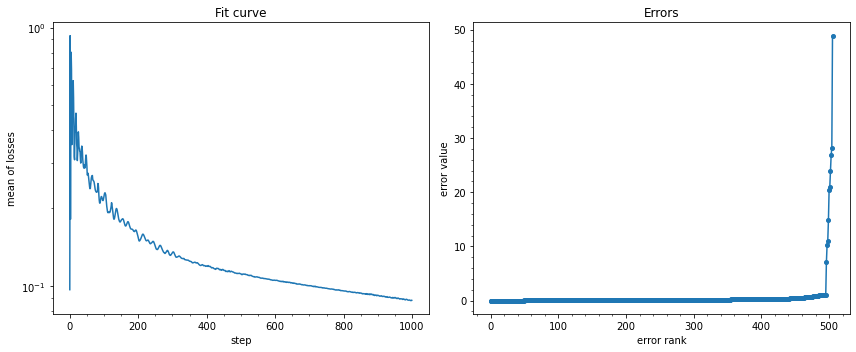

In [17]:
avg_22 = averaging_function("WM", rhofunc=func.Sqrt(0.001), alpha=0.98)
alg_fg2 = m_regression(Xt, Y, ffnn4, avrfunc=avg_22, h=0.01, n_restart=5, n_iter=1000)
plot_losses_and_errors(alg_fg2, Xt, Y)

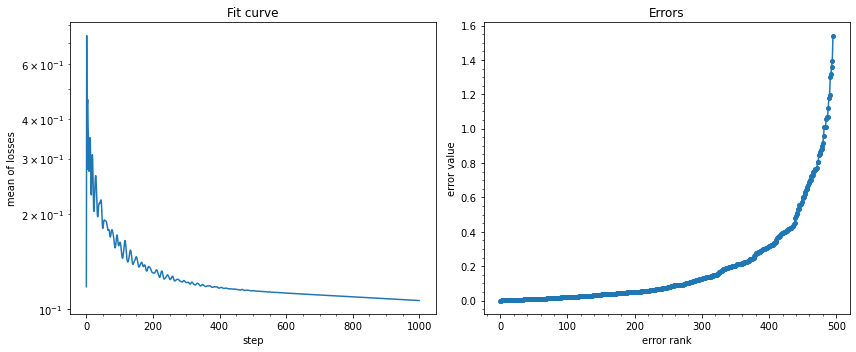

In [18]:
X_wo, Y_wo = exclude_outliers(ffnn3, Xt, Y, 10)
alg2 = regression(X_wo, Y_wo, ffnn5, h=0.01, n_restart=5, n_iter=1000)
plot_losses_and_errors(alg2, X_wo, Y_wo)

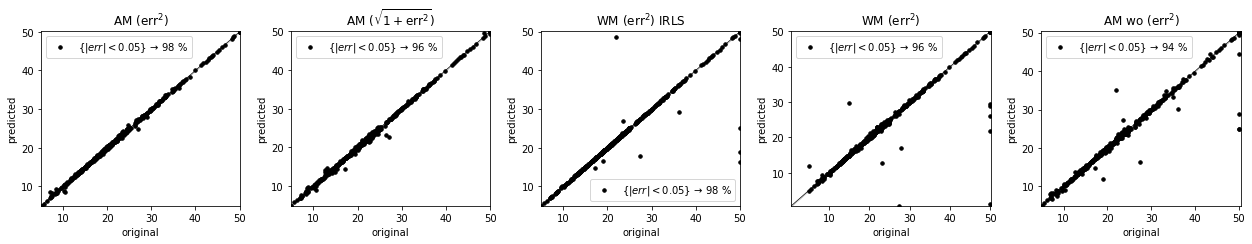

In [19]:
b=0.05
plt.figure(figsize=(5*3.5, 3.5))
plt.subplot(1,5,1)
plot_yy(Xt, Y, ffnn1, r'AM ($\mathrm{err}^2$)', b)
plt.subplot(1,5,2)
plot_yy(Xt, Y, ffnn2, r'AM ($\sqrt{1+\mathrm{err}^2}$)', b)
plt.subplot(1,5,3)
plot_yy(Xt, Y, ffnn3, r'WM ($\mathrm{err}^2$) IRLS', b)
plt.subplot(1,5,4)
plot_yy(Xt, Y, ffnn4, r'WM ($\mathrm{err}^2$)', b)
plt.subplot(1,5,5)
plot_yy(Xt, Y, ffnn5, r'AM wo ($\mathrm{err}^2$)', b)
plt.tight_layout()
plt.show()